In [1]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''



from __future__ import print_function

import numpy as np
import warnings
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import matplotlib.pyplot as plt
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

Using plaidml.keras.backend backend.


In [166]:


import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [5]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [6]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [144]:
# A function to preprocess all the images

def process_images(data_path):  
    
    # Define data path
    data_dir_list = os.listdir(data_path)
    
    # Defining target names
    target_names = list()
    target_names = data_dir_list[1:] # Starting from the first position to clip -> '.DS_Store'
    print('Summary of the dataset: \n')
    
    
    # Preprocessing the images
    img_data_list=[]
    label_num = 0
    count = 0
    samples = []
    for dataset in data_dir_list:
        if dataset != '.DS_Store':
            print('Importing - ', dataset, 'images.')
            img_list=os.listdir(data_path+'/'+ dataset)
            samples.append(len(img_list)-1)
            for img in img_list:

                if img != '.DS_Store':
                    img_path = data_path + '/'+ dataset + '/'+ img 
                    img = image.load_img(img_path, target_size=(224, 224))
                    x = image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)
                    img_data_list.append(x)
                

    # Converting the images into numpy arrays and arranging shape
    img_data = np.array(img_data_list)
    img_data = img_data.reshape((img_data.shape[0], 224,224,3))


    # Creating labels for our data
    labels = np.ones((sum(samples,)), dtype='int64')
    left_item_count = 0
    right_item_count = 0
    i = 0
    while i< len(samples):
        right_item_count += samples[i]
        labels[left_item_count:right_item_count] = i
        left_item_count=right_item_count
        i+=1
    print('\n\nClasses of the dataset: \n', target_names)
    print('\nRespective number of samples in each class: \n', samples)

    # Defining the number of classes
    num_classes = len(samples)

    # convert class labels to on-hot encoding
    one_hot_labels = np_utils.to_categorical(labels, num_classes)

    # Shuffling the input data
    x_shuffle_data, y_shuffle_data = shuffle(img_data, one_hot_labels, random_state=42)

    return x_shuffle_data, y_shuffle_data

In [186]:
# A function to print the results

def print_results(model, x_value, y_value, train = 'N'):
    
    # Run prediction using the model
    prediction = model.predict(x_value)
    
    # Convering the prediction and the labels from one hot encoding version to numerical numbers
    prediction = np.argmax(prediction, axis=1).tolist()
    y_value = np.argmax(y_value, axis=1).tolist()
    
    # Printing the classification on class basis
    print("\n\nClassification Report: \n\n" + classification_report(prediction, y_value, target_names = target_names))
    
    #Printing confusion matrix of the classification
    print("\n\n Confusion Matrix: \n")
    confusion_mtx = confusion_matrix(y_value, prediction)
    f,ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot accuracy and loss rates if it is training session
    if(train=='Y'):
        # summarize history for loss
        print("\n\nLoss history of the learninig process: ")
        plt.figure(figsize=(12,4))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Training model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        
        # Plotting the accuracy history
        print("\n\nAccuracy history of the learning process: ")
        plt.figure(figsize=(12,4))
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('Training model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [151]:
# Resnet50 trained on imagenet

baseModel = ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
baseModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [152]:
last_layer = baseModel.output

In [153]:
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

In [154]:
# add fully-connected & dropout layers
x = Dense(512, activation='relu',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)

In [155]:
# a softmax layer for 4 classes

num_classes = 4
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

In [156]:
# this is the model we will train
disaster_resnet50_model = Model(inputs=baseModel.input, outputs=out)
disaster_resnet50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [145]:
# Preprocess the image using the function above

x, y = process_images('/Users/fanusarefaine/disaster/train')

Summary of the dataset: 

Importing -  flood images.
Importing -  Wildfire images.
Importing -  earthquake images.
Importing -  cyclone images.


Classes of the dataset: 
 ['flood', 'Wildfire', 'earthquake', 'cyclone']

Respective number of samples in each class: 
 [693, 770, 1001, 601]


In [146]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [158]:
for layer in baseModel.layers:
	layer.trainable = False

In [159]:
disaster_resnet50_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [161]:
t=time.time()
history = disaster_resnet50_model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))

Train on 2452 samples, validate on 613 samples
Epoch 1/30
2432/2452 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9313

INFO:plaidml:Analyzing Ops: 1535 of 1774 operations complete


2452/2452 [==============================] - 76s 31ms/step - loss: 0.2588 - acc: 0.9307 - val_loss: 0.0550 - val_acc: 0.9821
Epoch 2/30
2452/2452 [==============================] - 70s 29ms/step - loss: 0.1540 - acc: 0.9507 - val_loss: 0.0368 - val_acc: 0.9902
Epoch 3/30
2452/2452 [==============================] - 61s 25ms/step - loss: 0.1205 - acc: 0.9621 - val_loss: 0.0309 - val_acc: 0.9869
Epoch 4/30
2452/2452 [==============================] - 60s 25ms/step - loss: 0.0824 - acc: 0.9743 - val_loss: 0.0368 - val_acc: 0.9869
Epoch 5/30
2452/2452 [==============================] - 60s 25ms/step - loss: 0.0822 - acc: 0.9723 - val_loss: 0.0589 - val_acc: 0.9788
Epoch 6/30
2452/2452 [==============================] - 61s 25ms/step - loss: 0.0651 - acc: 0.9755 - val_loss: 0.0733 - val_acc: 0.9755
Epoch 7/30
2452/2452 [==============================] - 61s 25ms/step - loss: 0.0632 - acc: 0.9804 - val_loss: 0.0312 - val_acc: 0.9869
Epoch 8/30
2452/2452 [==============================] - 61s

In [163]:
(loss, accuracy) = disaster_resnet50_model.evaluate(X_test, y_test, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

613/613 [==============================] - 33s 54ms/step
[INFO] loss=0.0380, accuracy: 98.3687%




Classification Report: 

              precision    recall  f1-score   support

       flood       0.99      0.96      0.97       144
    wildfire       0.99      0.99      0.99       152
  earthquake       0.97      0.99      0.98       194
     cyclone       0.99      0.99      0.99       123

    accuracy                           0.98       613
   macro avg       0.99      0.98      0.98       613
weighted avg       0.98      0.98      0.98       613



 Confusion Matrix: 



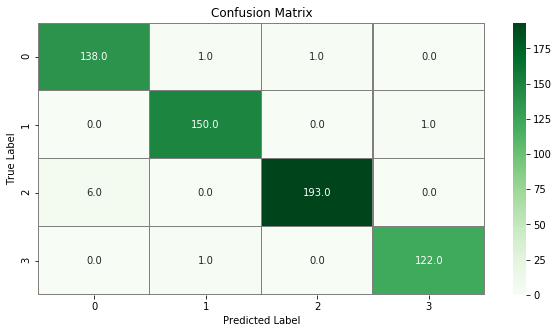



Loss history of the learninig process: 


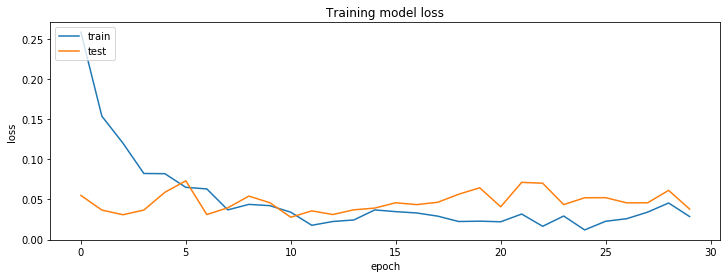



Accuracy history of the learning process: 


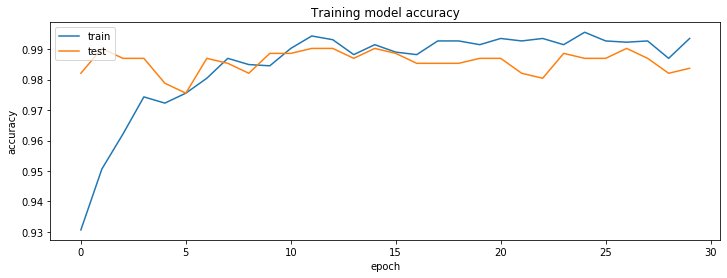

In [187]:
print_results(disaster_resnet50_model, X_test, y_test, train = 'Y')

# Validation

In [175]:
#Shuffle the dataset
x_val,y_val = process_images('/Users/fanusarefaine/disaster/validation')

Summary of the dataset: 

Importing -  flood images.
Importing -  wildfire images.
Importing -  earthquake images.
Importing -  cyclone images.


Classes of the dataset: 
 ['flood', 'wildfire', 'earthquake', 'cyclone']

Respective number of samples in each class: 
 [161, 140, 175, 163]


In [188]:
(loss, accuracy) = disaster_resnet50_model.evaluate(x_val, y_val, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

639/639 [==============================] - 23s 35ms/step
[INFO] loss=0.5035, accuracy: 92.8013%


Classification Report: 
              precision    recall  f1-score   support

       flood       0.90      0.87      0.89       166
    wildfire       0.96      0.93      0.94       144
  earthquake       0.90      0.93      0.92       168
     cyclone       0.96      0.98      0.97       161

    accuracy                           0.93       639
   macro avg       0.93      0.93      0.93       639
weighted avg       0.93      0.93      0.93       639



 Confusion Matrix: 



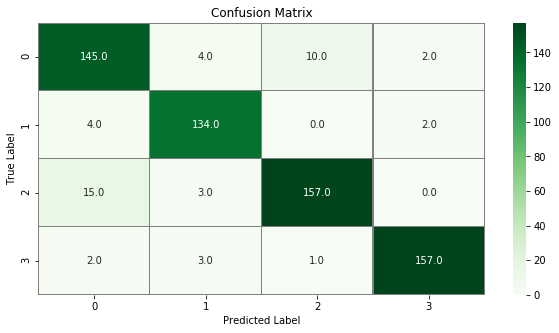

In [179]:
print_results(disaster_resnet50_model, x_val, y_val)

# Testing

In [189]:
x_test, y_test = process_images('/Users/fanusarefaine/disaster/test')

Summary of the dataset: 

Importing -  flood images.
Importing -  wildfire images.
Importing -  earthquake images.
Importing -  cyclone images.


Classes of the dataset: 
 ['flood', 'wildfire', 'earthquake', 'cyclone']

Respective number of samples in each class: 
 [219, 167, 174, 164]


In [191]:
(loss, accuracy) = disaster_resnet50_model.evaluate(x_test, y_test, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

724/724 [==============================] - 30s 41ms/step
[INFO] loss=0.3631, accuracy: 93.3702%




Classification Report: 

              precision    recall  f1-score   support

       flood       0.97      0.87      0.92       245
    wildfire       0.96      0.95      0.95       169
  earthquake       0.83      0.97      0.89       149
     cyclone       0.97      0.99      0.98       161

    accuracy                           0.93       724
   macro avg       0.93      0.94      0.94       724
weighted avg       0.94      0.93      0.93       724



 Confusion Matrix: 



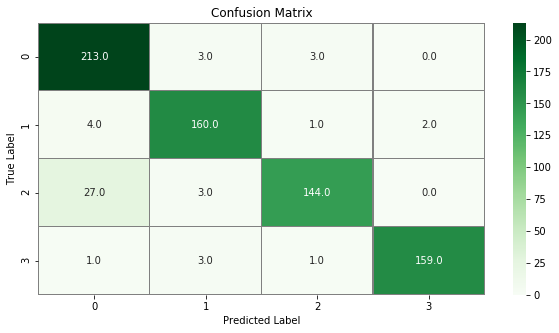

In [192]:
print_results(disaster_resnet50_model, x_test, y_test)

In [193]:
pwd

'/Users/fanusarefaine/disaster'

In [194]:
# save model and architecture to single file
disaster_resnet50_model.save("disaster_model.h5")
print("Saved model to disk")

Saved model to disk


In [211]:
disaster_resnet50_model.save("disaster_model.xml")